In [1]:
import gpytorch.kernels as kernel
import torch
from src.test_statistics import *
from src.data import *
import random
import numpy as np
from src.test import *

In [2]:
X_ker = kernel.RBFKernel()
Y_ker = kernel.RBFKernel()

In [3]:
X_ker

RBFKernel(
  (raw_lengthscale_constraint): Positive()
)

In [4]:
n=100
X = torch.randn((n,2))
Y = torch.randn(n)
T = (torch.randn((n))>0).float()

In [5]:
a =torch.tensor([1,1],dtype=float) 

In [6]:
data_train = Data_object(X,Y,T)
data_train_flip = Data_object(X,Y,1-T)

In [7]:
m= 200
X = torch.randn((m,2))
Y = torch.randn(m)
T = (torch.randn((m))>0).float()

In [8]:
Y1 = torch.randn((1))

In [9]:
data_test = Data_object(X,Y,T)
data_test_flip = Data_object(X,Y,1-T)

In [10]:
W0 = get_W_matrix(X_ker(data_train.X0).evaluate(),1)
W1 = get_W_matrix(Y_ker(data_train.X1).evaluate(),1)

TypeError: get_W_matrix() missing 1 required positional argument: 'func'

In [ ]:
weights = 1/2*torch.ones(m)

In [ ]:
K = ker(X_ker)
L = ker(Y_ker)

In [ ]:
c = (data_test.T - weights)/(weights*(1-weights))
c

tensor([ 2., -2., -2., -2.,  2., -2., -2., -2.,  2.,  2., -2., -2.,  2.,  2.,
         2., -2.,  2., -2.,  2., -2., -2.,  2., -2., -2., -2., -2., -2.,  2.,
         2.,  2.,  2.,  2.,  2., -2., -2.,  2.,  2.,  2., -2., -2.,  2.,  2.,
        -2.,  2.,  2., -2.,  2., -2.,  2.,  2., -2.,  2.,  2., -2., -2., -2.,
        -2.,  2.,  2., -2., -2., -2., -2., -2.,  2.,  2.,  2.,  2., -2.,  2.,
        -2.,  2., -2., -2., -2.,  2., -2.,  2.,  2.,  2.,  2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2.,  2.,  2.,  2., -2., -2.,  2., -2., -2.,
         2.,  2.,  2., -2., -2., -2., -2., -2.,  2.,  2., -2.,  2.,  2., -2.,
        -2.,  2.,  2., -2., -2.,  2., -2.,  2.,  2., -2.,  2., -2., -2., -2.,
         2., -2.,  2.,  2., -2.,  2., -2., -2.,  2., -2., -2., -2., -2.,  2.,
        -2., -2.,  2., -2., -2.,  2., -2.,  2., -2.,  2., -2., -2., -2.,  2.,
         2., -2., -2.,  2., -2.,  2., -2., -2., -2.,  2.,  2., -2.,  2.,  2.,
        -2., -2.,  2., -2.,  2., -2.,  2.,  2.,  2.,  2.,  2., -

In [ ]:
data_train.Y.shape

torch.Size([100])

In [ ]:
L(data_train.Y0,data_train.Y).shape

torch.Size([61, 100])

In [ ]:
DATE_test_stat(data_train,data_test,X_ker,Y_ker,weights,W0,W1)

0.021808069199323654

In [ ]:
DETT_test_stat(data_train,data_test,X_ker,Y_ker,weights,W1)

0.021705061197280884

In [ ]:
c

tensor([ 2., -2., -2., -2.,  2., -2., -2., -2.,  2.,  2., -2., -2.,  2.,  2.,
         2., -2.,  2., -2.,  2., -2., -2.,  2., -2., -2., -2., -2., -2.,  2.,
         2.,  2.,  2.,  2.,  2., -2., -2.,  2.,  2.,  2., -2., -2.,  2.,  2.,
        -2.,  2.,  2., -2.,  2., -2.,  2.,  2., -2.,  2.,  2., -2., -2., -2.,
        -2.,  2.,  2., -2., -2., -2., -2., -2.,  2.,  2.,  2.,  2., -2.,  2.,
        -2.,  2., -2., -2., -2.,  2., -2.,  2.,  2.,  2.,  2., -2., -2., -2.,
        -2., -2., -2., -2., -2., -2.,  2.,  2.,  2., -2., -2.,  2., -2., -2.,
         2.,  2.,  2., -2., -2., -2., -2., -2.,  2.,  2., -2.,  2.,  2., -2.,
        -2.,  2.,  2., -2., -2.,  2., -2.,  2.,  2., -2.,  2., -2., -2., -2.,
         2., -2.,  2.,  2., -2.,  2., -2., -2.,  2., -2., -2., -2., -2.,  2.,
        -2., -2.,  2., -2., -2.,  2., -2.,  2., -2.,  2., -2., -2., -2.,  2.,
         2., -2., -2.,  2., -2.,  2., -2., -2., -2.,  2.,  2., -2.,  2.,  2.,
        -2., -2.,  2., -2.,  2., -2.,  2.,  2.,  2.,  2.,  2., -

In [ ]:
L(data_train.Y0,data_test.Y)@ c

tensor([-1.8576e+01,  3.7889e-01, -1.0406e+00,  1.3422e+00,  3.1506e+00,
        -2.1562e+01, -1.8609e+01, -2.0348e+01, -1.2505e+01, -3.9996e+00,
        -6.1195e+00, -1.9195e+01, -1.9334e+01,  4.1174e+00, -1.9274e+01,
        -2.1423e+01, -1.9046e+01, -1.8291e+01, -2.1356e+01,  3.5617e+00,
        -1.4166e+01, -1.8786e+01, -1.8823e+01, -1.8522e+01, -1.9326e+01,
        -2.1619e+01, -1.8752e+01, -1.8833e+01, -1.8537e+01, -1.8775e+01,
        -1.4342e+01, -1.9105e+01, -2.4325e+00, -1.7252e+01, -1.8823e+01,
        -2.1524e+01, -1.4832e+01, -1.8309e+01, -1.8781e+01, -1.9059e+01,
        -1.8314e+01, -6.5300e+00, -1.5926e+01, -1.3494e+01, -2.1230e+01,
        -1.9223e+01, -1.9339e+01, -1.4459e+01, -1.8991e+01, -1.7885e+01,
        -1.1168e+01, -1.9294e+01, -1.9339e+01, -1.9310e+01, -1.0823e+01,
        -2.1682e+01, -1.2495e+00, -1.9195e+01, -1.3525e-02, -1.9008e+01,
        -1.7011e+01], grad_fn=<MvBackward0>)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
weights_model = LogisticRegression()

In [ ]:
weights_model.fit(data_train.X,data_train.T)
weights_train = weights_model.predict_proba(data_train.X)[:,1]
weights_test = weights_model.predict_proba(data_test.X)[:,1]

In [ ]:
result_dict = kernel_permutation_test(data_train,data_test,X_ker,Y_ker,weights_model,test_stat="DETT",n_bins=10,n_permutations=100,reg=1)

In [ ]:
g = lambda X: X[:,0]**2 + X[:,1] 

mu = torch.tensor([0,0.5])
sigma = ["ID"]
g_0 = g
g_1 = g
noise = 0.1
n_sample =100

In [ ]:
a = shift_data_simulation(mu,sigma,g_0,g_1,noise,n_sample)

/Users/jakefawkes/Python/DR_distributional_test/src/data.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = torch.tensor(mu)


In [ ]:
import yaml
import src.data as data

In [ ]:
f = getattr(data,"shift_data_simulation")

In [ ]:
with open("/Users/jakefawkes/Python/DR_distributional_test/config/run_simulated_experiment.yaml", "r") as f:
    cfg = yaml.safe_load(f)


In [ ]:
cfg

{'experiment': {'n_iter': 20,
  'test_stat': ['DATE', 'DETT'],
  'weights_model': 'GP',
  'X_ker': 'RBF',
  'Y_ker': 'RBF',
  'significance_level': 0.05,
  'n_bins': 20,
  'cme_reg': 1,
  'permute_weights': True},
 'data': {'generator': 'shift_data_simulation',
  'n_train_sample': 200,
  'n_test_sample': 200,
  'arguments': {'mu': [0, 0], 'sigma': ['C_ID', 2], 'noise': 0.2},
  'functions': {'g_0': 'f_0', 'g_1': 'f_0'}}}

In [ ]:
def make_data(cfg):
    if cfg["data"]["generator"] == "shift_data_simulation":
        function_dict = {}
        for key in cfg["data"]["functions"]:
            function_dict[key] = getattr(data,cfg["data"]["functions"][key])
    data_train = shift_data_simulation(n_sample=cfg["data"]["n_train_sample"],**function_dict,**cfg["data"]["arguments"])
    data_test = shift_data_simulation(n_sample=cfg["data"]["n_test_sample"],**function_dict,**cfg["data"]["arguments"])
    return data_train,data_test

In [ ]:
make_data(cfg)

(<src.data.Data_object at 0x7f8f7eb4ba00>,
 <src.data.Data_object at 0x7f8f7eb17880>)

In [ ]:
function_dict = {}
for key in cfg["data"]["functions"]:
    function_dict[key] = getattr(data,cfg["data"]["functions"][key])

In [ ]:
a = shift_data_simulation(mu,sigma,g_0,g_1,noise,n_sample)

In [ ]:
shift_data_simulation(n_sample=cfg["data"]["n_train_sample"],**function_dict,**cfg["data"]["arguments"])

In [ ]:
float(True)

1.0

In [ ]:
import pandas as pd

In [ ]:
df_dict = {"Y":a.Y,"T":a.T}
df = pd.DataFrame(np.array(a.X))
df.columns = ["X"+str(i) for i in df.columns]

In [ ]:
df["Y"] = a.Y
df["T"] = a.T

In [ ]:
df

,X0,X1,Y,T
0,0.981722,-0.156104,0.769015,0.0
1,-0.111455,-1.461071,-1.503008,0.0
2,0.719052,0.297878,0.652724,0.0
3,-0.707723,-0.739237,-0.295330,0.0
4,0.287614,0.255651,0.437334,0.0
...,...,...,...,...
95,0.111641,1.239888,1.190036,1.0
96,0.839082,0.407945,1.110951,1.0
97,0.517359,-0.051988,0.154538,1.0
98,0.524800,0.340914,0.459360,1.0


In [ ]:
import seaborn as sns

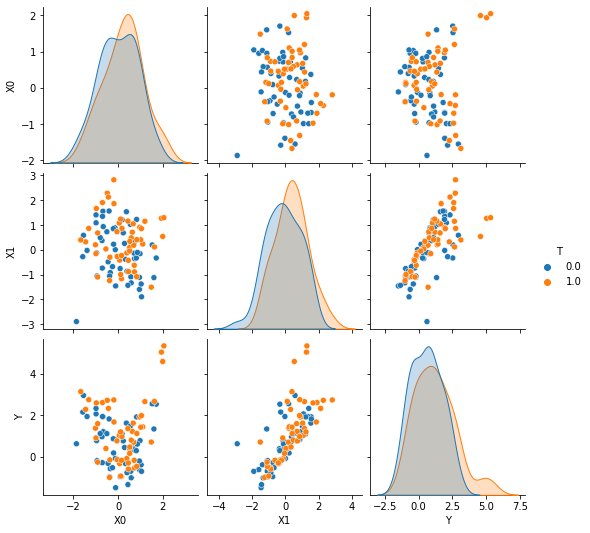

In [ ]:
b = sns.pairplot(df, hue ="T")

In [ ]:
from datetime import datetime


In [ ]:
now = datetime.now()

In [ ]:
now.strftime("%m-%d %H:%M:%S")

'06-05 12:15:43'

In [ ]:
df_dict = {"weights" : weights_model.predict_proba(data_test.X)[:,1], "T" : data_test.T}

In [ ]:
df = pd.DataFrame(df_dict)

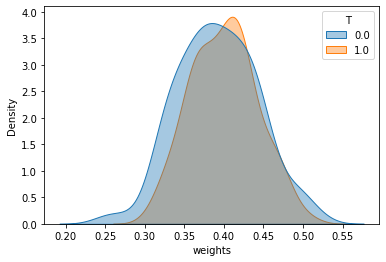

In [ ]:
a = sns.kdeplot(data = df, x="weights", hue ="T",fill=True, alpha = 0.4)

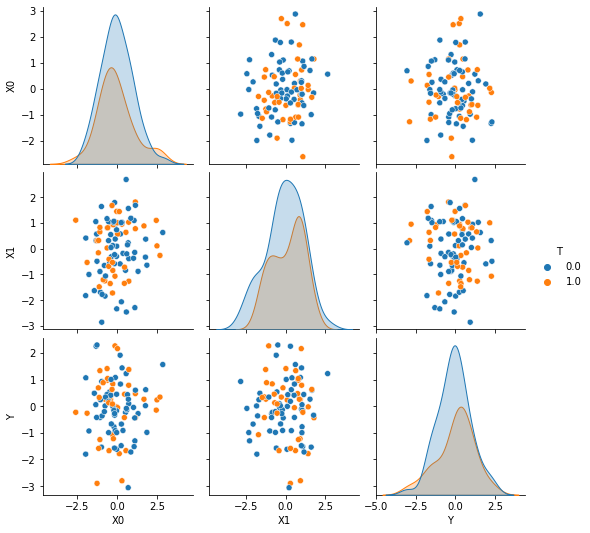

In [ ]:
a = data_train.plot_data()

In [ ]:
if "str":
    print("y")

y


In [ ]:
a =[1,1]

In [ ]:
if type(a) == list:
    print("y")

y


In [50]:
def linear_data_simulation(alpha_vec,beta_vec,beta_scalar,effect_var,noise_Y,n_sample):

    alpha_vec = torch.tensor(alpha_vec).float()
    beta_vec = torch.tensor(beta_vec).float()

    d = len(alpha_vec)

    X = torch.randn((n_sample,d)).float()
    T = torch.bernoulli(torch.sigmoid( X @ alpha_vec ))
    
    if effect_var == "const":
        effect_vec = torch.ones(n_sample)

    if effect_var == "Ber":
        effect_vec = 2*torch.bernoulli(1/2*torch.ones(n_sample))-1

    if effect_var == "Unif":
        effect_vec = 2*torch.rand(n_sample)-1

    Y =  X @ alpha_vec + beta_scalar * effect_vec + noise_Y * torch.randn((n_sample))

    return Data_object(X,Y,T)

In [52]:
alpha_vec = [1,1]
beta_vec = [1,1]
beta_scalar = 1
effect_var = "Ber"
noise_Y = 1
n_sample = 100
a= linear_data_simulation(alpha_vec,beta_vec,beta_scalar,effect_var,noise_Y,n_sample)

In [54]:
a.Y

tensor([-1.1203,  0.9123, -4.8318, -2.3435, -0.0331,  0.1026, -0.4234, -3.0084,
         0.9110, -0.6814, -2.1144, -1.0330, -0.8309, -2.3338, -1.5157, -0.6613,
         0.6262, -1.5319, -3.3765,  3.0171,  2.1560,  2.2302,  5.5910, -3.3055,
         0.7460, -4.9458, -0.5564, -0.2029,  2.3425,  0.8546, -1.1401,  3.2390,
        -0.4038,  0.9571,  3.3055, -0.3827,  2.8676,  0.0499, -0.8194,  2.4084,
        -0.8279,  3.5541,  1.5900,  1.1757,  1.5335, -4.5121, -1.0604, -0.1469,
         2.1295,  0.7164, -1.2477,  1.7319, -2.2967,  3.1392, -2.4231,  1.0586,
         0.8797, -0.9310, -0.7625,  0.5531,  1.2321,  0.8800, -1.8060,  0.6009,
         3.0851,  1.1633, -2.4763,  2.2710, -1.9332,  1.7350,  1.3312, -1.0200,
         0.2841, -2.7479,  0.8005, -3.3042,  0.4862,  0.8857,  1.0074, -1.1750,
         0.2140, -1.3338,  3.7525,  1.4794,  2.5629,  0.0633, -0.2302,  2.5341,
        -1.1725, -1.1644, -2.2868,  1.7606, -1.0512, -1.5699, -2.8640,  0.1073,
        -1.4334, -1.3814,  0.2898,  1.62

In [46]:
alpha_vec = torch.tensor(alpha_vec).float()
beta_vec = torch.tensor(beta_vec).float()

d = len(alpha_vec)

X = torch.randn((n_sample,d)).float()
T = torch.bernoulli(torch.sigmoid( X @ alpha_vec ))

if effect_var == "const":
    effect_vec = torch.ones(d)

if effect_var == "Ber":
    effect_vec = 2*torch.bernoulli(1/2*torch.ones(n_sample))-1

if effect_var == "Unif":
    effect_vec = 2*torch.rand(d)-1

Y =  X @ alpha_vec + beta_scalar * effect_vec + noise_Y * torch.randn((n_sample))


RuntimeError: The size of tensor a (100) must match the size of tensor b (2) at non-singleton dimension 0

In [71]:
def cme_cross_validate_target(data_train,data_val,X_ker,Y_ker,reg_param):
        
        K = ker(X_ker)
        L = ker(Y_ker)

        W0 = get_W_matrix(X_ker(data_train.X0).evaluate(),reg_param,"cme")
        W1 = get_W_matrix(X_ker(data_train.X1).evaluate(),reg_param,"cme")

        val_stat_0 = torch.trace(L(data_val.Y0,data_val.Y0) -2 * K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_val.Y0)))+ (K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_train.Y0)@ (W0 @ (K(data_train.X0,data_val.X0)))))))
        val_stat_1 = torch.trace(L(data_val.Y1,data_val.Y1) -2 * K(data_train.X1,data_val.X1).T @ (W1 @ (L(data_train.Y1,data_val.Y1)))+ (K(data_train.X1,data_val.X1).T @ (W0 @ (L(data_train.Y1,data_train.Y1)@ (W0 @ (K(data_train.X1,data_val.X1)))))))
        val_stat = val_stat_0+val_stat_1
        return val_stat

In [87]:
def cme_cross_validate_target(data_train,data_val,X_ker,Y_ker,reg_param):
        
        K = ker(X_ker)
        L = ker(Y_ker)

        W0 = get_W_matrix(X_ker(data_train.X0).evaluate(),reg_param,"cme")
        W1 = get_W_matrix(X_ker(data_train.X1).evaluate(),reg_param,"cme")

        val_stat_0 = torch.trace(L(data_val.Y0,data_val.Y0) -2 * K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_val.Y0)))+ (K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_train.Y0)@ (W0 @ (K(data_train.X0,data_val.X0)))))))
        val_stat_1 = torch.trace(L(data_val.Y1,data_val.Y1) -2 * K(data_train.X1,data_val.X1).T @ (W1 @ (L(data_train.Y1,data_val.Y1)))+ (K(data_train.X1,data_val.X1).T @ (W0 @ (L(data_train.Y1,data_train.Y1)@ (W0 @ (K(data_train.X1,data_val.X1)))))))
        val_stat = val_stat_0+val_stat_1
        return val_stat

In [88]:
data_train = linear_data_simulation(alpha_vec,beta_vec,beta_scalar,effect_var,noise_Y,n_sample)
data_val = linear_data_simulation(alpha_vec,beta_vec,beta_scalar,effect_var,noise_Y,n_sample)
cme_cross_validate_target(data_train,data_val,X_ker,Y_ker,reg_param=1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (54x54 and 46x53)

In [90]:
K = ker(X_ker)
L = ker(Y_ker)
W0 = get_W_matrix(X_ker(data_train.X0).evaluate(),1,"cme")
W1 = get_W_matrix(X_ker(data_train.X1).evaluate(),1,"cme")

In [91]:
L(data_val.Y0,data_val.Y0) -2 * K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_val.Y0)))+ (K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_train.Y0)@ (W0 @ (K(data_train.X0,data_val.X0))))))

tensor([[ 9.9899e-01, -1.7912e-05, -7.2239e-04,  ..., -2.1512e-03,
          9.9610e-01, -2.8325e-03],
        [ 2.3175e-03,  9.9901e-01,  1.7634e-02,  ...,  9.5097e-01,
          3.1784e-03,  5.8537e-01],
        [-7.6054e-04,  1.5502e-02,  9.9925e-01,  ...,  3.8882e-02,
         -7.9067e-04,  1.9348e-01],
        ...,
        [ 7.3645e-04,  9.4885e-01,  3.9533e-02,  ...,  9.9697e-01,
          1.0316e-03,  7.6887e-01],
        [ 9.9573e-01,  2.4274e-03, -1.1594e-04,  ..., -1.6510e-05,
          9.9858e-01, -8.4564e-04],
        [-6.8898e-04,  5.8142e-01,  1.9440e-01,  ...,  7.6749e-01,
         -7.0406e-04,  9.9649e-01]], grad_fn=<AddBackward0>)

In [94]:
L(data_val.Y1,data_val.Y1) -2 * K(data_train.X1,data_val.X1).T @ (W1 @ (L(data_train.Y1,data_val.Y1)))+ (K(data_train.X1,data_val.X1).T @ (W0 @ (L(data_train.Y1,data_train.Y1)@ (W0 @ (K(data_train.X1,data_val.X1))))))

tensor([[ 9.9774e-01,  2.7117e-01,  4.0640e-01,  ..., -5.3781e-04,
         -3.7141e-05, -3.9930e-04],
        [ 2.7137e-01,  9.9777e-01,  9.6120e-01,  ...,  2.1140e-02,
          5.1879e-06, -7.8222e-04],
        [ 4.0445e-01,  9.5898e-01,  9.9542e-01,  ...,  6.3382e-03,
         -4.9074e-04, -1.0023e-04],
        ...,
        [-4.8895e-03,  1.6630e-02,  4.7994e-03,  ...,  9.9686e-01,
          4.1936e-02, -1.7148e-04],
        [-1.0166e-04, -1.6844e-04, -1.4119e-04,  ...,  4.2098e-02,
          9.9985e-01, -6.5386e-06],
        [-1.3763e-03, -1.2005e-03, -1.2871e-03,  ..., -1.8203e-04,
          7.2287e-06,  9.9986e-01]], grad_fn=<SubBackward0>)

In [80]:
X_ker(data_train.X0).evaluate().shape

torch.Size([53, 53])

In [81]:
def get_W_matrix(K_X,c,func):
    if func == "cme":
        return torch.cholesky_inverse(K_X + c * K_X.shape[0] * torch.eye(K_X.shape[0]))
    if func == "zero":
        return torch.zeros((K_X.shape[0],K_X.shape[0]))

In [83]:
get_W_matrix(X_ker(data_train.X0).evaluate(),1,"cme").shape

torch.Size([53, 53])